In [13]:
import math
import numpy as np
from IPython.display import clear_output
import pdb
import time
import matplotlib.pyplot as plt
import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
from torchdiffeq import odeint_adjoint as odeint
from torch.distributions import MultivariateNormal
use_cuda = torch.cuda.is_available()
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import gc
import importlib
import Utils
importlib.reload(Utils)
from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory
from Utils import SaveTrajectory as st
import ODEModel
importlib.reload(ODEModel)
from ODEModel import ODEfunc, Siren
from ODEModel import FfjordModel
import LearnTraj
importlib.reload(LearnTraj);
from LearnTraj import learn_trajectory
import os;

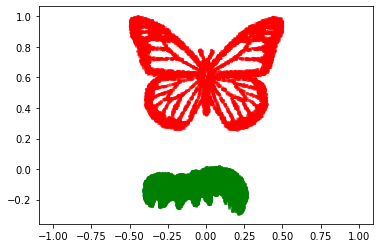

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
caterpillar,im = ImageDataset.import_img('caterpillar.png'); caterpillar=1-caterpillar; caterpillar/=caterpillar.max();
butterfly,im = ImageDataset.import_img('butterfly.jpg'); butterfly=255-butterfly; butterfly/=butterfly.max();
circle,im = ImageDataset.import_img('circle.jpeg'); circle=255-circle; circle/=circle.max();
square,im = ImageDataset.import_img('square.png', rgb_weights=[0.2989, 0.5870, 0.1140,0]); square=1-square; square/=square.max();
cat1,im = ImageDataset.import_img('cat1.png', rgb_weights = [0.2989, 0.5870, 0.1140, 1]); cat1/=cat1.max();
dset1 = ImageDataset(img=caterpillar*1,thresh=.8); 
dset2 = ImageDataset(img=butterfly*1,thresh=.8)
dset3 = ImageDataset(img=circle*1,thresh=.8)
dset4 = ImageDataset(img=square*1,thresh=.8)
dset5 = ImageDataset(img=cat1*1,thresh=.8)

n = 10000; 
dat1 = dset1.sample(n); 
dat2 = dset2.sample(n); 
dat3 = dset3.sample(n)*.7;
dat4 = dset4.sample(n);
dat5 = dset5.sample(n);
dat1*=-1; dat1[:,1]-=.1;
dat2*=-1; dat2[:,1]+=.5; 
dat3[:,1]+=1.5;
dat5[:,1]*=-1;

plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='green')
plt.scatter(dat2.detach().numpy()[:,0],dat2.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='red')
# plt.scatter(dat3.detach().numpy()[:,0],dat3.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='magenta')
# plt.scatter(dat4.detach().numpy()[:,0],dat4.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='orange')
# plt.scatter(dat5.detach().numpy()[:,0],dat5.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='yellow')
plt.axis('equal')
plt.show() 

training with sinkhorn_large_reg
lr 0.0001
batch 0 loss tensor(1., device='cuda:0')


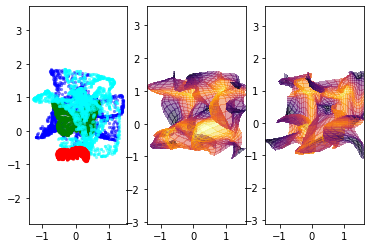

time elapsed 0.3148066997528076 total time 0.3145594596862793
batch number 0 out of 2000
savetime 2.384185791015625e-07
lr 0.0001
batch 150 loss tensor(0.1750, device='cuda:0', grad_fn=<DivBackward0>)


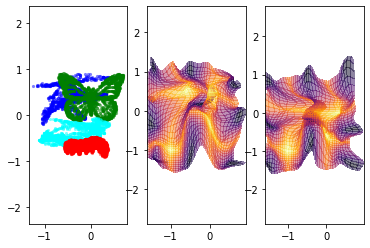

time elapsed 15.447551012039185 total time 15.768387079238892
batch number 150 out of 2000
savetime 2.8259201049804688
lr 0.0001
batch 300 loss tensor(0.0598, device='cuda:0', grad_fn=<DivBackward0>)


<Figure size 432x288 with 0 Axes>

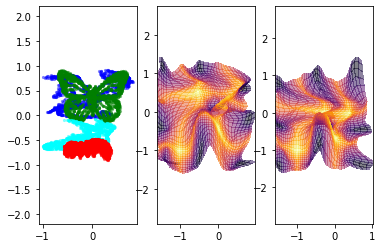

time elapsed 15.158812761306763 total time 33.75348687171936
batch number 300 out of 2000
savetime 2.7738869190216064
lr 0.0001
batch 450 loss tensor(0.0421, device='cuda:0', grad_fn=<DivBackward0>)


<Figure size 432x288 with 0 Axes>

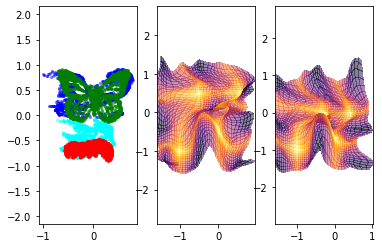

time elapsed 15.001893997192383 total time 51.53003907203674
batch number 450 out of 2000
savetime 2.8528406620025635
lr 0.0001
batch 600 loss tensor(0.0358, device='cuda:0', grad_fn=<DivBackward0>)


<Figure size 432x288 with 0 Axes>

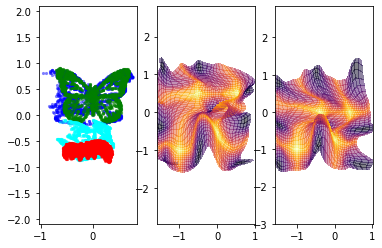

time elapsed 15.411011457443237 total time 69.79419779777527
batch number 600 out of 2000
savetime 2.93546462059021
lr 0.0001
batch 750 loss tensor(0.0337, device='cuda:0', grad_fn=<DivBackward0>)


<Figure size 432x288 with 0 Axes>

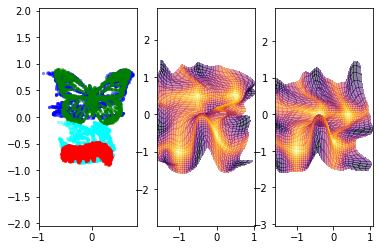

time elapsed 15.399779319763184 total time 88.13024401664734
batch number 750 out of 2000
savetime 2.7766926288604736
lr 0.0001
batch 900 loss tensor(0.0322, device='cuda:0', grad_fn=<DivBackward0>)


<Figure size 432x288 with 0 Axes>

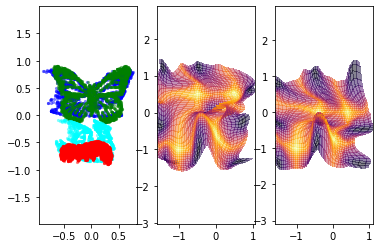

time elapsed 15.1166672706604 total time 106.02445125579834
batch number 900 out of 2000
savetime 2.8902454376220703
lr 0.0001
batch 1050 loss tensor(0.0304, device='cuda:0', grad_fn=<DivBackward0>)


<Figure size 432x288 with 0 Axes>

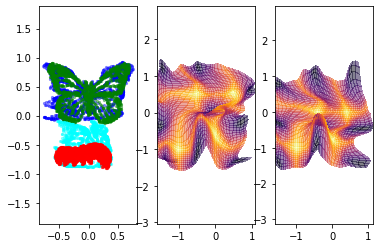

time elapsed 15.224662780761719 total time 124.14034414291382
batch number 1050 out of 2000
savetime 2.8942677974700928
lr 0.0001
batch 1200 loss tensor(0.0300, device='cuda:0', grad_fn=<DivBackward0>)


<Figure size 432x288 with 0 Axes>

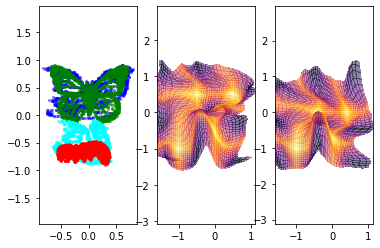

time elapsed 15.204045057296753 total time 142.23946237564087
batch number 1200 out of 2000
savetime 2.8028581142425537
lr 0.0001
batch 1350 loss tensor(0.0304, device='cuda:0', grad_fn=<DivBackward0>)


<Figure size 432x288 with 0 Axes>

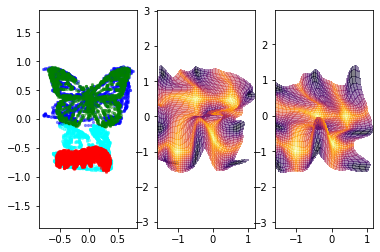

time elapsed 15.168384790420532 total time 160.21173882484436
batch number 1350 out of 2000


In [ ]:
z_target = ImageDataset.normalize_samples(torch.stack((dat2, dat1)).to(device));
model = Siren(first_omega_0=20).to(device); 
# model.load_state('models/seq_state420_time_31.615391731262207.tar');
# model.load_state('models/state310_time_22.49951934814453.tar');
# model.load_state('models/state_start.tar');
# for my_loss in ['sinkhorn_small_reg']:
# my_loss = 'sinkhorn_small_reg';
my_loss = 'sinkhorn_large_reg';
# %prun 
model, losses, separate_losses, lrs, n_subs = learn_trajectory(z_target, my_loss=my_loss,n_iters = 2000,n_subsample=2000, model=model, save=True)

In [ ]:
# st.gpu_usage()
# z_target.shape
# z_target = ImageDataset.normalize_samples(torch.stack((dat2, dat1)).to(device));

# torch.cuda.empty_cache()
# z_target = ImageDataset.normalize_samples(torch.stack((dat2, dat1)).to(device));
# model = FfjordModel().to(device); model.load_state('models/state_start.tar'); # print(next(model.parameters()).is_cuda)
# my_loss = 'sinkhorn_large_reg';
myln = my_loss+'_0';
st.save_trajectory(model,z_target[:,1:4000,:],myln, savedir='imgs', nsteps=100, memory=0.01, n=500,dpiv=400)
st.gpu_usage()
st.trajectory_to_video(myln, savedir='imgs', mp4_fn='transform.mp4')

# integration_times = torch.linspace(0,z_target.shape[0]-1,2).to(device);
# model(z_target[1,:,:], integration_times)


In [ ]:
torch.cuda.empty_cache() 
st.gpu_usage()

In [ ]:
# test what weights are given to what frequencies in the first layer
for param in model.parameters():
    print(type(param.data), param.size())
    pdat = param.data;
    break;    
pmags = torch.norm(param.data,p=2,dim=0);
freqs = model.time_deriv_func.imap.B;
nf = freqs.shape[0];
nd = (pmags.shape[0]-2*nf)

fmags = torch.norm(freqs,p=2,dim=1);
xyfreqs = torch.cat([fmags, fmags],dim=0);
print(xyfreqs.size())

plt.plot(xyfreqs.cpu().numpy(), pmags[0:(nf*2)].cpu().numpy(),'.')
plt.plot(np.zeros(nd), pmags[(nf*2):].cpu().numpy(),'.')
plt.savefig(os.path.join('./', f"viz_freqs.jpg"),dpi=400); 
# # freqs
# # fmags

In [ ]:
start=100;end=60000;
plt.plot(losses[start:end]); 
# plt.plot(separate_losses[0,start:end],'g'); 
# plt.plot(separate_losses[1,start:end],'r'); 
# plt.plot(separate_losses[2,start:end]); 
plt.plot(separate_losses[3,start:end]*.01,'r'); 
plt.plot(separate_losses[4,start:end]*10,'b'); 
# plt.plot(separate_losses[5,start:end]); 
# plt.plot(separate_losses[6,start:end]);
plt.savefig(os.path.join('./', f"viz_loss.jpg"),dpi=400); 

In [ ]:
(fig,(ax1,ax2))=plt.subplots(2,1)
ax1.plot(n_subs[start:end],'r'); ax1.set_ylabel('n_sub')
ax2.plot(lrs[start:end],'g'); ax2.set_ylabel('lr') 
plt.savefig(os.path.join('./', f"viz_stat.jpg"),dpi=400); 

In [ ]:
## visualize ending sinkhorn costs as gradient on point clouds
# z_target = ImageDataset.normalize_samples(torch.stack((dat1,dat4)).to(device));
T = z_target.shape[0];

z_t = model(z_target[0,:,:], integration_times = torch.linspace(0,T-1,T).to(device),reverse=False);
z_t_b = model(z_target[T-1,:,:], integration_times = torch.linspace(0,T-1,T).to(device),reverse=True);
forward = z_t[T-1,:,:].cpu().detach().numpy();
backward = z_t_b[T-1,:,:].cpu().detach().numpy();

my_loss_f = SamplesLoss("sinkhorn", p=2, blur=0.01);
loss_f = my_loss_f(z_target[T-1,:,:], z_t[T-1,:,:])
loss_b = my_loss_f(z_target[0,:,:], z_t_b[T-1,:,:])

graddirs_f = torch.autograd.grad(loss_f, z_t)[0][T-1,:,:]
graddirs_b = torch.autograd.grad(loss_b, z_t_b)[0][T-1,:,:]

pos_f = z_t.cpu().detach().numpy()
pos_b = z_t_b.cpu().detach().numpy()
dirs_f = graddirs_f.cpu().detach().numpy()
dirs_b = graddirs_b.cpu().detach().numpy()

import os
plt.axis('equal')
plt.scatter(pos_b[0,:,0], pos_b[0,:,1], s=10, alpha=.5, linewidths=0, c='green', edgecolors='black')
plt.scatter(forward[:,0], forward[:,1], s=10, alpha=.5, linewidths=0, c='red', edgecolors='black')
plt.quiver(pos_f[T-1,:,0], pos_f[T-1,:,1], dirs_f[:,0], dirs_f[:,1],scale=.0001)
plt.savefig(os.path.join('./', f"viz_backward.jpg"),dpi=400); plt.clf()

plt.axis('equal')
plt.scatter(pos_f[0,:,0], pos_f[0,:,1], s=10, alpha=.5, linewidths=0, c='green', edgecolors='black')
plt.scatter(backward[:,0], backward[:,1], s=10, alpha=.5, linewidths=0, c='red', edgecolors='black')
plt.quiver(pos_b[T-1,:,0], pos_b[T-1,:,1], dirs_b[:,0], dirs_b[:,1],scale=.0001)
plt.savefig(os.path.join('./', f"viz_forward.jpg"),dpi=400); 


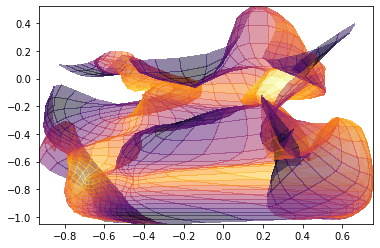

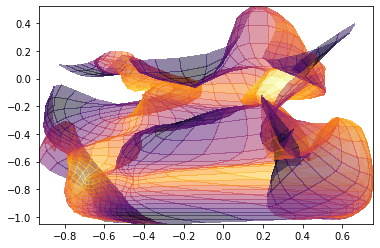

In [274]:
bound = 1.1;
t=1;
N = 40;
dx = 2*bound/(N-1)
xvals = torch.linspace(-bound,bound,N)
X, Y = torch.meshgrid(xvals, xvals)
Xc = X[:-1,:-1] + dx/2
Yc = Y[:-1,:-1] + dx/2
z = torch.sqrt((Xc-Xc.round())**2 + (Yc-Yc.round())**2)
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

tt = torch.tensor(t);
XYi = torch.cat((X.reshape((-1,1)), Y.reshape((-1,1)), tt.repeat(N**2,1)),dim=1);
(XYo,blah) = model(XYi.to(device))
Xo = XYo[:,0].reshape((N,N)).detach().cpu().numpy()
Yo = XYo[:,1].reshape((N,N)).detach().cpu().numpy()

ti = .5; 
Xt = X*(1-ti)+Xo*ti
Yt = Y*(1-ti)+Yo*ti
plt.pcolormesh(Xt, Yt, z, edgecolors = 'none', alpha=.5, cmap='inferno')
plt.show()
plt.pcolormesh(Xt, Yt, z, edgecolors = 'none', alpha=.5, cmap='inferno')


In [ ]:
#trying other shapes

square = np.zeros([20,20])
square[6:14,:8] = 1

two_square = np.zeros([20,20])
two_square[:5,14:] = 1
two_square[15:,14:] = 1


annulus = import_img('annulus.png')
circle = 255-import_img('circle.jpeg')

dset = ImageDataset(img=square)
dset1 = ImageDataset(img=two_square)

n = 500
dat = dset.sample(n)
dat1 = dset1.sample(n)
plt.scatter(dat.detach().numpy()[:,0],dat.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='red')
plt.show() 

In [ ]:
# make half moon dataset
import sklearn.datasets

moons, labels = sklearn.datasets.make_moons(n,noise=.1) #generates two half moons
mask = (labels == 0)
one_moon = moons[mask,:] # only keep one moon

def rot_mat(theta0):
    #computes rotation matrix of angle theta
    return np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])

theta0 = np.pi/2
theta1 = np.pi

rot0 = rot_mat(theta0)
rot1 = rot_mat(theta1)

# apply rotation to the moon
one_moon_rot0 = np.dot(one_moon,rot0)
one_moon_rot1 = np.dot(one_moon,rot1)

In [ ]:
#visualize rotated moons

plt.scatter(one_moon[:,0],one_moon[:,1], color='blue')
plt.scatter(one_moon_rot0[:,0],one_moon_rot0[:,1], color='orange')
plt.scatter(one_moon_rot1[:,0],one_moon_rot1[:,1], color='green')

In [ ]:
# with three timesteps

dat = torch.tensor(one_moon,dtype=torch.float)
dat0 = torch.tensor(one_moon_rot0,dtype=torch.float)
dat1 = torch.tensor(one_moon_rot1,dtype=torch.float)

dat_tuple = (dat,dat0,dat1)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
# with two timesteps


dat_tuple = (dat,dat0)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
losses